In [27]:
# ------------------ IMPORTS ------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm  # CNN backbones shiz
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torchmetrics
import wandb
import pandas as pd
import numpy as np
import time
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import shutil
import random
from pathlib import Path
from tabulate import tabulate

In [28]:
# ------------------ DEVICE CONFIG ------------------
# using CUDA for the RTX 3050 Mobile 4GiB variant
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}")


Using device: cuda


In [29]:
# ------------------ SPLITTING ------------------

def split_dataset(
    src_dir,
    out_dir="data",
    train_ratio=0.6,
    val_ratio=0.3,
    test_ratio=0.1,
    img_extensions=(".jpg", ".jpeg", ".png"),
):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, (
        "Ratios must sum to 1"
    )
    random.seed(42)

    src_dir = Path(src_dir)
    out_dir = Path(out_dir)
    class_dirs = [d for d in src_dir.iterdir() if d.is_dir()]

    for cls_path in class_dirs:
        cls_name = cls_path.name
        images = [f for f in cls_path.glob("*") if f.suffix.lower() in img_extensions]

        random.shuffle(images)
        n = len(images)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)

        splits = {
            "train": images[:n_train],
            "val": images[n_train : n_train + n_val],
            "test": images[n_train + n_val :],
        }

        for split, files in splits.items():
            split_dir = out_dir / split / cls_name
            split_dir.mkdir(parents=True, exist_ok=True)
            for file in files:
                shutil.copy(file, split_dir / file.name)

        print(
            f"{cls_name}: {n} images train={len(splits['train'])}, val={len(splits['val'])}, test={len(splits['test'])}"
        )



raw_data_path = "data/raw"
final_output_path = "data"

split_dataset(
    src_dir=raw_data_path,
    out_dir=final_output_path,
    train_ratio=0.6,
    val_ratio=0.3,
    test_ratio=0.1,
)


Apple_Black_Rot: 621 images train=372, val=186, test=63
Apple_Cedar_Rust: 275 images train=165, val=82, test=28
Apple_Healthy: 1645 images train=987, val=493, test=165
Apple_Scab: 630 images train=378, val=189, test=63


In [30]:
# ------------------ PATHS AND HYPERPARAMETERS ------------------
DATA_ROOT = "./data"  # contains all data divided into raw test train val folders 
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR = os.path.join(DATA_ROOT, "val")
TEST_DIR = os.path.join(DATA_ROOT, "test")

# basic training parameters, tweak these for fun 
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 1e-4 
EPOCHS = 50


In [31]:
#------------------ WANDB INITIALISATION ------------------
wandb.init(
    project="cnn-hybrid-transformer", 
    config={                     # Log hyperparameters
        "learning_rate": LEARNING_RATE,
        "architecture": "HybridCNNTransformer",
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "image_size": IMG_SIZE,
    }
)

In [32]:
# ------------------ DATA AUGMENTATION AND DATALOADERS ------------------
# Adding transforms to add variety 
train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    ]
)

# center crop and resize
val_test_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# image loading datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_test_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_test_transform)

# shuffling and creating pockets using dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

class_names = train_dataset.classes
print(f"Classes found: {class_names}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")


Classes found: ['Apple_Black_Rot', 'Apple_Cedar_Rust', 'Apple_Healthy', 'Apple_Scab']
Training images: 1902
Validation images: 950
Test images: 319


In [33]:
# ------------------ MODEL DEFINITION ------------------
class HybridCNNTransformer(nn.Module):
    
    """
    Hybrid CNN + Transformer model for image classification.

    - CNN Backbone: EfficientNet-B0 for feature extraction.
    - Projection: 1x1 convolution to convert CNN features to embeddings for Transformer.
    - Transformer Encoder: stacks multi-head self-attention layers.
    - Classification head: Dense layer on CLS token output for final classes.
    """

    def __init__(self, num_classes):
        super(HybridCNNTransformer, self).__init__()

        # 1. CNN Backbone - remove final classifier, keep feature extractor.
        self.cnn_backbone = timm.create_model(
            "efficientnet_b0", pretrained=False, num_classes=0, global_pool=""
        )
        cnn_feature_dim = self.cnn_backbone.num_features

        # add extra features under this one as discussed in the meeting lol
        # self.norm = nn.BatchNorm2d(cnn_feature_dim)
        # self.extra_conv = nn.Conv2d(cnn_feature_dim, cnn_feature_dim, kernel_size=3, padding=1)
        # self.cnn_dropout = nn.Dropout2d(0.2)

        # 2. Project CNN feature maps into transformer embedding dimension.
        embed_dim = 256
        self.projection = nn.Conv2d(cnn_feature_dim, embed_dim, kernel_size=1)

        # 3. Transformer Encoder setup
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=8, batch_first=True, dropout=0.2
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)

        # Learnable [CLS] token prepended to the sequence
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Dropout before classification head
        self.dropout = nn.Dropout(0.5)

        # Final classification layer
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # propagation ✨
        x = self.cnn_backbone(x)
        # referring to the thing above, also add layers here coz why not 
        # x = self.norm(x)
        # x = self.extra_conv(x)
        # x = self.cnn_dropout(x)

        # Project CNN features to transformer dimension
        x = self.projection(x)

        # Flatten spatial dimensions to sequence tokens
        b, c, h, w = x.shape
        x = x.flatten(2).permute(0, 2, 1)  # Shape: (B, Seq_len, Emb_dim)

        # Prepend CLS token to sequence (for global representation)
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Transformer Encoder forward pass
        x = self.transformer_encoder(x)

        # Extract CLS token output
        cls_output = x[:, 0]
        cls_output = self.dropout(cls_output)

        # Classification head produces final logits
        output = self.fc(cls_output)
        return output


model = HybridCNNTransformer(num_classes=len(class_names)).to(device)


In [34]:
# ------------------ TRAINING SETUP ------------------

# for reproducibility, so results don’t keep changing every run 😭
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)

criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification

# optimiser coming in clutch (AdamW with weight decay to reduce overfitting)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# learning rate scheduler because otherwise training plateaus early
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_val_accuracy = 0.0  # this will help in saving the best model, basically a counter

# ------------------ METRICS SETUP ------------------
num_classes = len(class_names)

# training metrics (just accuracy is fine, precision/recall not super needed here)
train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(
    device
)

# validation metrics (need the full set for paper credibility)
val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(
    device
)
val_precision = torchmetrics.Precision(task="multiclass", num_classes=num_classes).to(
    device
)
val_recall = torchmetrics.Recall(task="multiclass", num_classes=num_classes).to(device)
val_f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes).to(device)

# dictionary to store training logs (for graphs later 📈)
training_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}


# ------------------ PRETTY PRINTING ------------------
def colorize(value, thresholds, colors, width=10):
    """
    Helper function for color-coded console output.
    Example:
        - low values => RED
        - medium => YELLOW
        - good => GREEN
    """
    val_str = f"{value:<{width}.4f}"
    if value < thresholds[0]:
        return f"{colors[0]}{val_str}{RESET}"
    elif value < thresholds[1]:
        return f"{colors[1]}{val_str}{RESET}"
    else:
        return f"{colors[2]}{val_str}{RESET}"


# ANSI color codes for console logging
RED = "\033[91m"
YELLOW = "\033[93m"
GREEN = "\033[92m"
CYAN = "\033[96m"
RESET = "\033[0m"


In [35]:
# ------------------ TRAINING LOOP ------------------

# beg wandb to watch your model
wandb.watch(model, log="all", log_freq=100)

# initialize automatic mixed precision (AMP) scaler for FP16 training
scaler = torch.amp.GradScaler('cuda')

for epoch in range(EPOCHS):
    epoch_start_time = time.time()

    model.train()
    train_loss = 0.0
    train_accuracy.reset()

    # tqdm for progress
    train_loader_tqdm = tqdm(
        train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Train]", leave=False
    )
    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # mixed precision 
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        train_accuracy.update(outputs, labels)

        # optional eye candy
        train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_train_acc = train_accuracy.compute()
    avg_train_loss = train_loss / len(train_loader)

    # validation fr
    model.eval()
    val_loss = 0.0
    # purge old shit
    val_accuracy.reset()
    val_precision.reset()
    val_recall.reset()
    val_f1.reset()

    # more tqdm brrr
    val_loader_tqdm = tqdm(
        val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Val]", leave=False
    )
    with torch.no_grad():
        for inputs, labels in val_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss += loss.item()

            # out with the old, in with the new
            val_accuracy.update(outputs, labels)
            val_precision.update(outputs, labels)
            val_recall.update(outputs, labels)
            val_f1.update(outputs, labels)

    final_acc = val_accuracy.compute()
    final_precision = val_precision.compute()
    final_recall = val_recall.compute()
    final_f1 = val_f1.compute()
    avg_val_loss = val_loss / len(val_loader)

    # update scheduler
    scheduler.step()

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    # goated for a reason
    wandb.log(
        {
            "epoch": epoch + 1,
            "train/loss": avg_train_loss,
            "eval/loss": avg_val_loss,
            "eval/accuracy": final_acc,
            "eval/precision": final_precision,
            "eval/recall": final_recall,
            "eval/f1": final_f1,
            "train/accuracy": epoch_train_acc,
            "lr": scheduler.get_last_lr()[0],
        }
    )

    training_history["train_loss"].append(avg_train_loss)
    training_history["val_loss"].append(avg_val_loss)
    training_history["train_acc"].append(float(epoch_train_acc.cpu()))
    training_history["val_acc"].append(float(final_acc.cpu()))

    # simple printing 
    if epoch == 0:
        table_headers = [
            "Epoch",
            "Train Loss",
            "Val Loss",
            "Train Acc",
            "Val Acc",
            "Val F1",
            "Time(s)",
        ]
        table_rows = []

    # Colorized values
    colored_train_loss = colorize(
        avg_train_loss, (0.5, 1.0), (GREEN, YELLOW, RED)
    )  # adjusted thresholds
    colored_val_loss = colorize(avg_val_loss, (0.5, 1.0), (GREEN, YELLOW, RED))
    colored_train_acc = colorize(epoch_train_acc, (0.8, 0.95), (RED, YELLOW, GREEN))
    colored_val_acc = colorize(final_acc, (0.8, 0.95), (RED, YELLOW, GREEN))
    colored_val_f1 = colorize(final_f1, (0.8, 0.95), (RED, YELLOW, GREEN))

    # Determine if this epoch is the new best
    if final_acc > best_val_accuracy:
        best_val_accuracy = final_acc
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "best_val_acc": best_val_accuracy,
            },
            "best_model.pth",
        )
        # Highlight epoch number in cyan
        epoch_label = f"{CYAN}{epoch + 1}{RESET}"
    else:
        epoch_label = f"{epoch + 1}"

    # Append formatted row
    table_rows.append(
        [
            epoch_label,
            colored_train_loss,
            colored_val_loss,
            colored_train_acc,
            colored_val_acc,
            colored_val_f1,
            f"{epoch_duration:.2f}",
        ]
    )

    # Clear previous table (to avoid repeated prints)
    print("\033[2J\033[H", end="")

    # Reprint full table
    print(
        "\n"
        + tabulate(
            table_rows,
            headers=table_headers,
            tablefmt="rounded_grid",
            numalign="right",
            stralign="center",
        )
    )

# convert to a pandas obj and save as csv
history_df = pd.DataFrame(training_history)
os.makedirs("results", exist_ok=True)
history_df.to_csv("results/training_history.csv", index_label="epoch")


Epoch 1/50 [Train]:   0%|          | 0/60 [00:00<?, ?it/s]


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
╰─────────┴──────────────┴────────────┴─────────────┴───────────┴──────────┴───────────╯



╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
╰─────────┴──────────────┴────────────┴─────────────┴───────────┴──────────┴───────────╯



╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
╰─────────┴──────────────┴────────────┴─────────────┴───────────┴──────────┴───────────╯



╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
╰─────────┴──────────────┴────────────┴─────────────┴───────────┴──────────┴───────────╯



╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2237 │     0.8679 │      0.4732 │    0.5853 │   0.5853 │     36.02 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9005 │     0.7265 │      0.6356 │    0.6989 │   0.6989 │     27.82 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8243 │     0.6536 │       0.654 │    0.7284 │   0.7284 │     28.57 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.7044 │     0.6122 │       0.715 │    0.7726 │   0.7726 │     27.14 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.

In [36]:
# # ------------------ FINAL TESTING & REPORT ------------------
# print("--- Loading best model for final testing ---")
# model.load_state_dict(torch.load("best_model.pth"))
# model.eval()

# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # Classification metrics report
# print("Classification Report (Test Set):")
# print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# # Confusion matrix heatmap
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(10, 8))
# sns.heatmap(
#     cm,
#     annot=True,
#     fmt="d",
#     cmap="Blues",
#     xticklabels=class_names,
#     yticklabels=class_names,
# )
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix (Test Set)")
# plt.show()


🔥 Final Evaluation on Test Set - Let's see what we've built!
📥 Loading the best model...
   ✅ Loaded model from epoch 42
   📊 Best validation accuracy: 0.9432
🚀 Running inference on test set...


Processing batches: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


✅ Collected 319 predictions!
📊 Core metrics calculated!
📈 Plotting training curves...


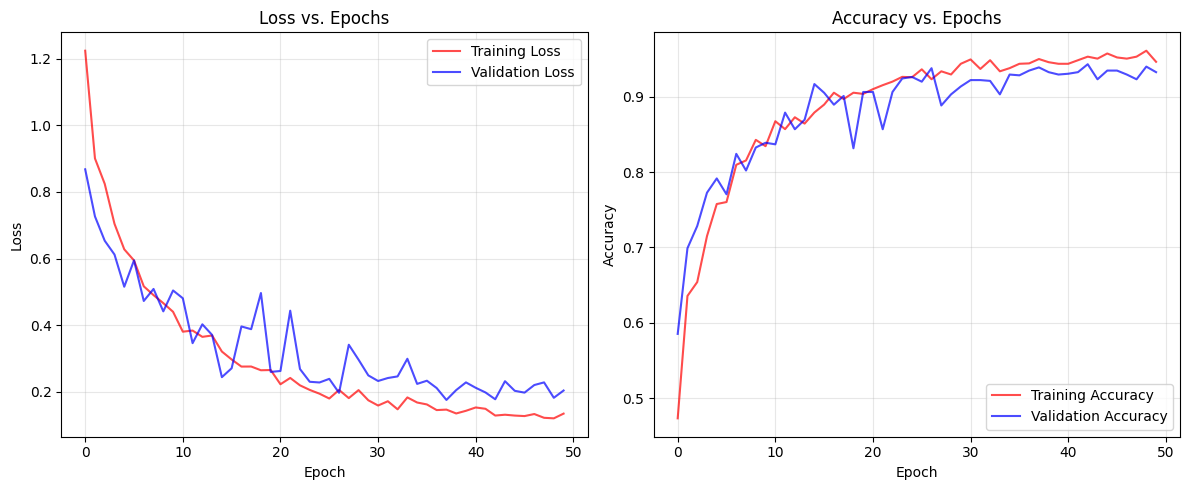

📝 Generating classification report...
--- Classification Report (Test Set) ---
                  precision    recall  f1-score   support

 Apple_Black_Rot     0.9828    0.9048    0.9421        63
Apple_Cedar_Rust     1.0000    1.0000    1.0000        28
   Apple_Healthy     0.9061    0.9939    0.9480       165
      Apple_Scab     0.9615    0.7937    0.8696        63

        accuracy                         0.9373       319
       macro avg     0.9626    0.9231    0.9399       319
    weighted avg     0.9404    0.9373    0.9359       319



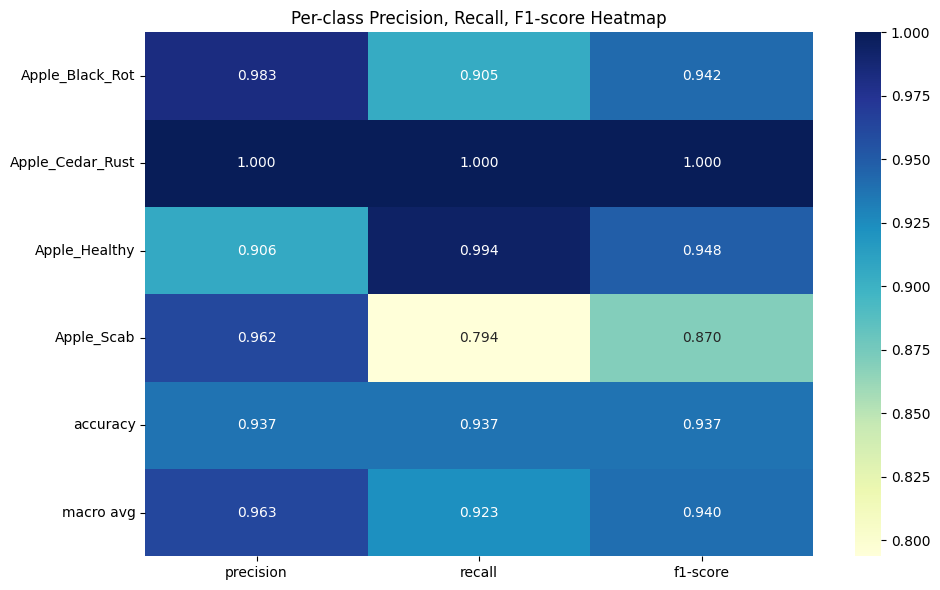

🎯 Creating confusion matrices...


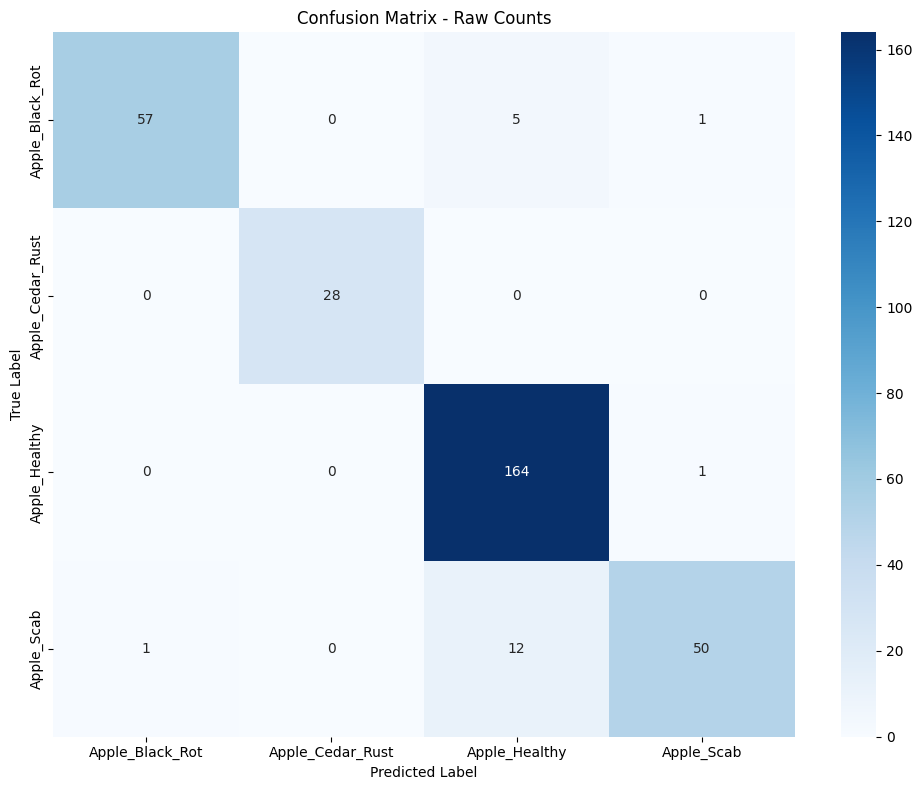

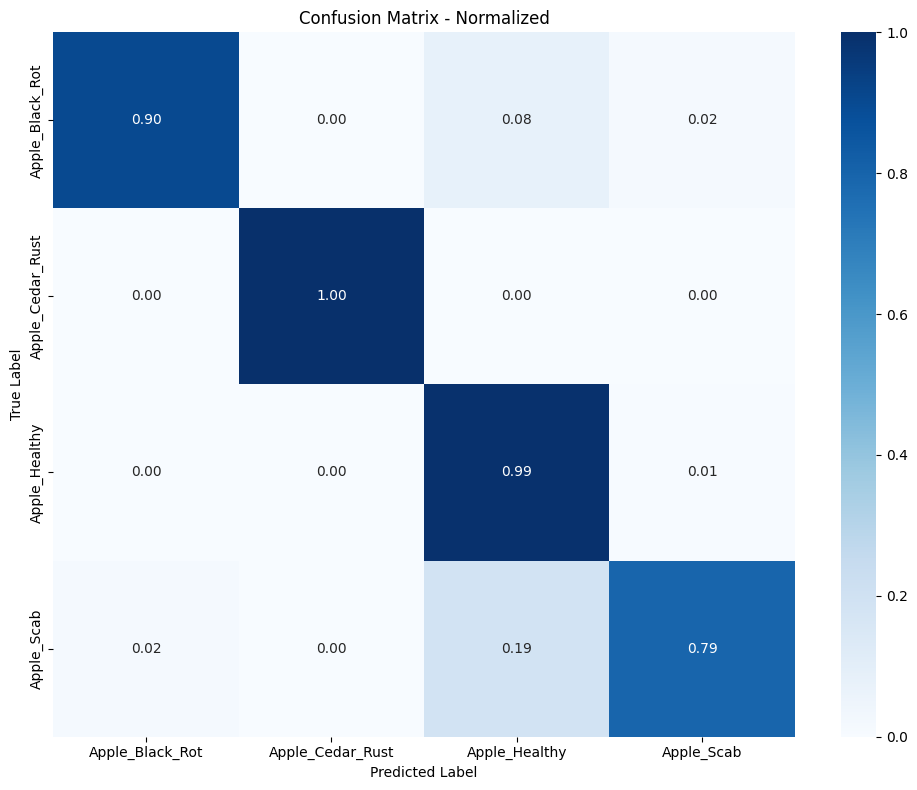

📊 Generating ROC curves...


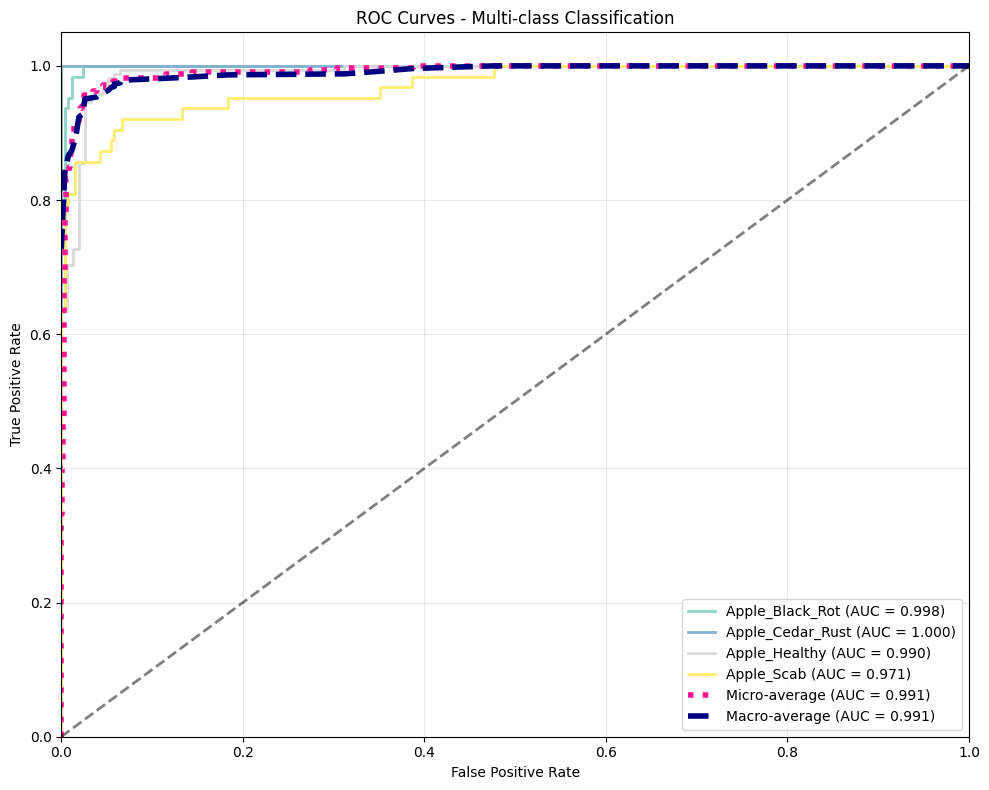

📈 Creating Precision-Recall curves...


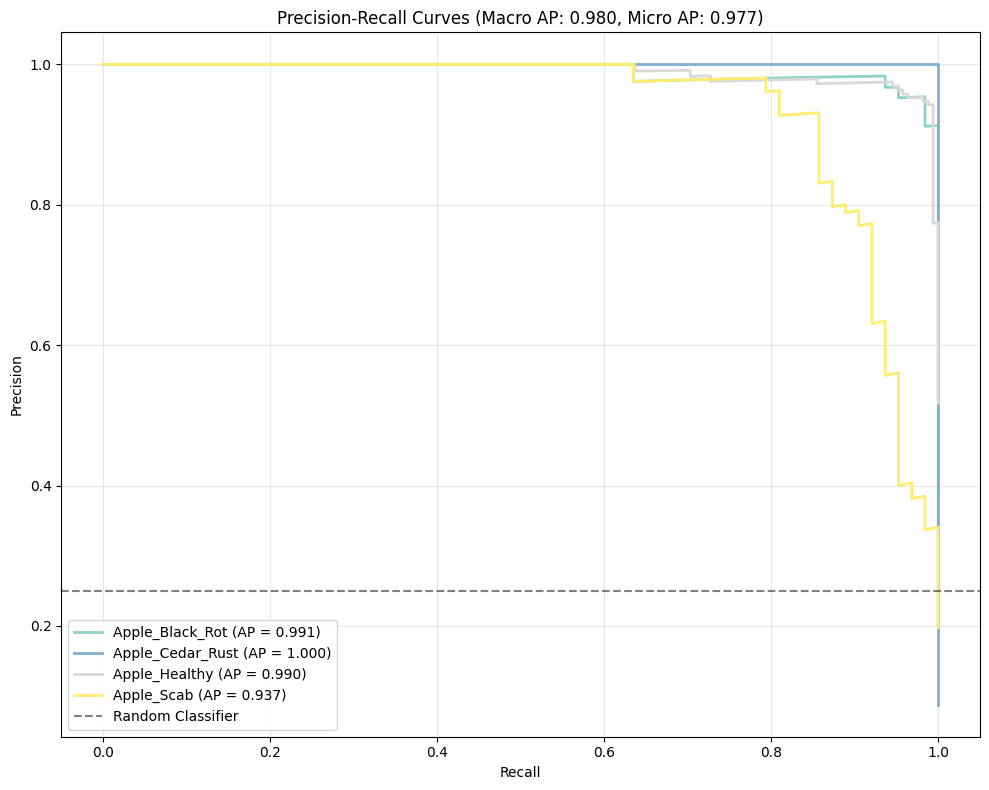

🎨 Creating t-SNE visualization of feature embeddings...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 319 samples in 0.000s...
[t-SNE] Computed neighbors for 319 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 319 / 319
[t-SNE] Mean sigma: 2.128042
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.688633
[t-SNE] KL divergence after 1000 iterations: 0.209274


C:\Users\neved\AppData\Local\Temp\ipykernel_22100\1302181719.py:436: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=plt.cm.tab10(label), label=class_names[label])


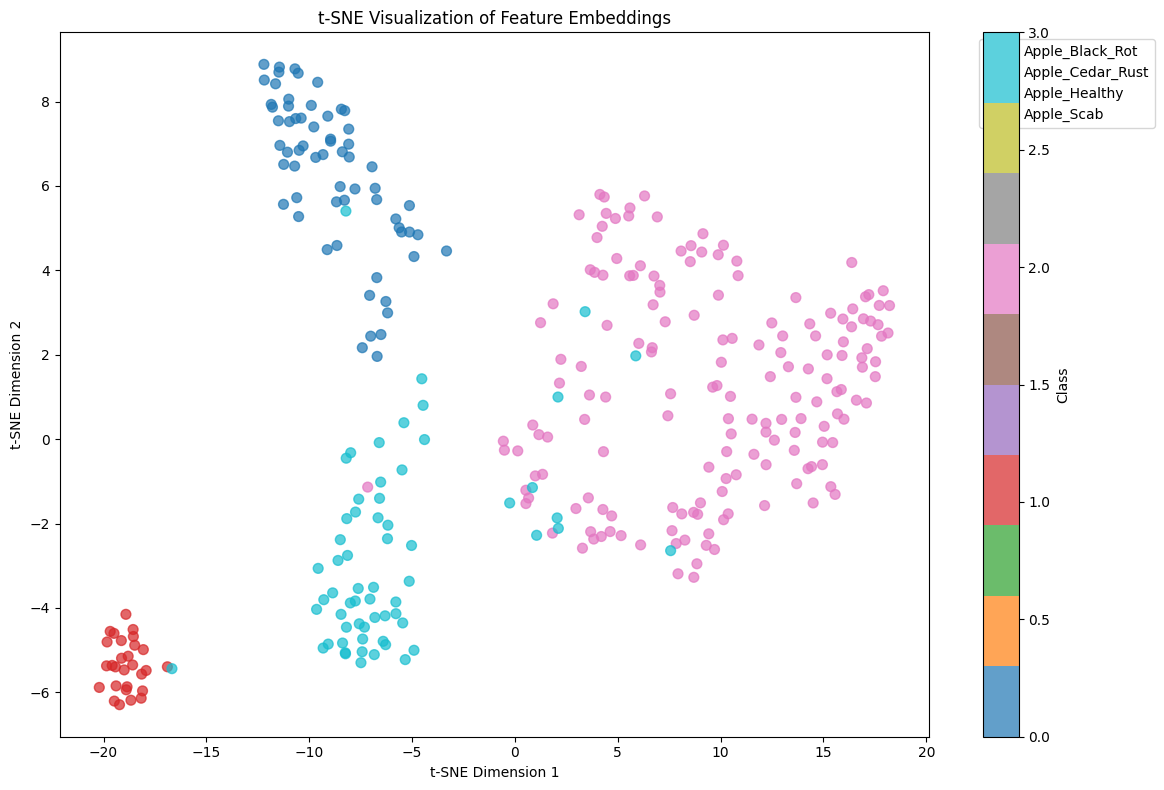

📋 Compiling final metrics...

🏆 FINAL EVALUATION SUMMARY
+---------------------+---------+------------------+
| Metric              |   Value | 95% CI           |
+=====================+=========+==================+
| Accuracy            |  0.9373 | [0.9121, 0.9624] |
+---------------------+---------+------------------+
| F1 (Macro)          |  0.9399 | [0.9140, 0.9638] |
+---------------------+---------+------------------+
| F1 (Micro)          |  0.9373 | -                |
+---------------------+---------+------------------+
| MCC                 |  0.9038 | [0.8632, 0.9415] |
+---------------------+---------+------------------+
| Cohen's Kappa       |  0.9006 | -                |
+---------------------+---------+------------------+
| ROC AUC (Macro)     |  0.9908 | -                |
+---------------------+---------+------------------+
| ROC AUC (Micro)     |  0.9913 | -                |
+---------------------+---------+------------------+
| PR AUC (Macro)      |  0.9796 | -       

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


📈 Interactive plots added to WandB!
🔄 Finishing WandB run...


Final/Accuracy,▁
Final/Accuracy_CI_Lower,▁
Final/Accuracy_CI_Upper,▁
Final/Avg_Inference_Time_ms,▁
Final/Cohen_Kappa,▁
Final/F1_Macro,▁
Final/F1_Macro_CI_Lower,▁
Final/F1_Macro_CI_Upper,▁
Final/F1_Micro,▁
Final/MCC,▁
Final/MCC_CI_Lower,▁



🎯 All done! Your model evaluation is complete and properly logged.


In [ ]:
# ------------------ FINAL TESTING, REPORTING & PLOTTING ------------------
print("🔥 Final Evaluation on Test Set - Let's see what we've built!")

# Suppress multiprocessing warnings (because they're just noise)
import warnings

warnings.filterwarnings(
    "ignore", category=UserWarning, module="torch.utils.data.dataloader"
)

# Create results directory
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Load the best model saved during training
print("📥 Loading the best model...")

# Handle different checkpoint formats - because saving formats can be tricky
checkpoint = torch.load("best_model.pth", map_location=device)

if isinstance(checkpoint, dict):
    if "model_state_dict" in checkpoint:
        # Full checkpoint with training metadata
        model.load_state_dict(checkpoint["model_state_dict"])
        print(f"   ✅ Loaded model from epoch {checkpoint.get('epoch', 'unknown')}")
        if "best_val_acc" in checkpoint:
            print(f"   📊 Best validation accuracy: {checkpoint['best_val_acc']:.4f}")
    elif "state_dict" in checkpoint:
        # Alternative checkpoint format
        model.load_state_dict(checkpoint["state_dict"])
    else:
        # Direct state dict
        model.load_state_dict(checkpoint)
else:
    # Legacy format - direct model weights
    model.load_state_dict(checkpoint)

model.to(device)
model.eval()

# --- A. DATA COLLECTION FROM TEST SET (with feature extraction shiz) ---
all_preds = []
all_labels = []
all_probs = []
inference_times = []

# This hook will capture the output of the layer before the final classifier
feature_embeddings = []


def hook(module, input, output):
    """Hook to capture feature embeddings"""
    feature_embeddings.append(output.detach().cpu().numpy())


# Attach the hook to the dropout layer right before the final `self.fc` layer
hook_handle = model.dropout.register_forward_hook(hook)

print("🚀 Running inference on test set...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Processing batches"):
        inputs, labels = inputs.to(device), labels.to(device)

        start_time = time.time()
        outputs = model(inputs)
        end_time = time.time()

        inference_times.append(
            (end_time - start_time) / inputs.size(0)
        )  # Time per image

        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Important: Remove the hook after use (cleanup is key!)
hook_handle.remove()

# Convert to numpy arrays for easier processing
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_embeddings = np.concatenate(feature_embeddings, axis=0)

print(f"✅ Collected {len(all_preds)} predictions!")


# --- B. BOOTSTRAP CONFIDENCE INTERVALS (because uncertainty matters) ---
def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstraps=1000, ci=95):
    """Bootstrap confidence intervals - proper statistical rigor"""
    stats = []
    n = len(y_true)
    rng = np.random.default_rng(42)
    for _ in range(n_bootstraps):
        idx = rng.choice(np.arange(n), n, replace=True)
        stats.append(metric_fn(y_true[idx], y_pred[idx]))
    lower = np.percentile(stats, (100 - ci) / 2)
    upper = np.percentile(stats, 100 - (100 - ci) / 2)
    return lower, upper


# --- C. COMPREHENSIVE METRICS CALCULATION ---
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    matthews_corrcoef,
    cohen_kappa_score,
)
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE

# Basic metrics
acc = accuracy_score(all_labels, all_preds)
prec_macro = precision_score(all_labels, all_preds, average="macro", zero_division=0)
prec_micro = precision_score(all_labels, all_preds, average="micro", zero_division=0)
rec_macro = recall_score(all_labels, all_preds, average="macro", zero_division=0)
rec_micro = recall_score(all_labels, all_preds, average="micro", zero_division=0)
f1_macro = f1_score(all_labels, all_preds, average="macro", zero_division=0)
f1_micro = f1_score(all_labels, all_preds, average="micro", zero_division=0)
mcc = matthews_corrcoef(all_labels, all_preds)
kappa = cohen_kappa_score(all_labels, all_preds)

# Confidence intervals for key metrics
acc_ci = bootstrap_ci(lambda yt, yp: accuracy_score(yt, yp), all_labels, all_preds)
f1_macro_ci = bootstrap_ci(
    lambda yt, yp: f1_score(yt, yp, average="macro"), all_labels, all_preds
)
mcc_ci = bootstrap_ci(lambda yt, yp: matthews_corrcoef(yt, yp), all_labels, all_preds)

# Average inference time
avg_inference_time = np.mean(inference_times)

print("📊 Core metrics calculated!")

# --- D. GENERATE AND SAVE ALL THE ARTIFACTS ---

# 1. Training & Validation Curves (if history exists)
if os.path.exists(f"{output_dir}/training_history.csv"):
    print("📈 Plotting training curves...")
    history_df = pd.read_csv(f"{output_dir}/training_history.csv")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(
        history_df["epoch"],
        history_df["train_loss"],
        label="Training Loss",
        color="red",
        alpha=0.7,
    )
    plt.plot(
        history_df["epoch"],
        history_df["val_loss"],
        label="Validation Loss",
        color="blue",
        alpha=0.7,
    )
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    if "train_acc" in history_df.columns:
        plt.plot(
            history_df["epoch"],
            history_df["train_acc"],
            label="Training Accuracy",
            color="red",
            alpha=0.7,
        )
    plt.plot(
        history_df["epoch"],
        history_df["val_acc"],
        label="Validation Accuracy",
        color="blue",
        alpha=0.7,
    )
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/training_curves.png", dpi=300, bbox_inches="tight")
    wandb.log(
        {"Charts/Training_Curves": wandb.Image(f"{output_dir}/training_curves.png")}
    )
    plt.show()

# 2. Classification Report (detailed per-class metrics)
print("📝 Generating classification report...")
report = classification_report(
    all_labels, all_preds, target_names=class_names, digits=4
)
print("--- Classification Report (Test Set) ---")
print(report)

# Save text report
with open(f"{output_dir}/classification_report.txt", "w") as f:
    f.write(report)

# Save as structured data
report_dict = classification_report(
    all_labels, all_preds, target_names=class_names, output_dict=True, digits=4
)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(f"{output_dir}/classification_metrics.csv")

# Heatmap of per-class metrics
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Per-class Precision, Recall, F1-score Heatmap")
plt.tight_layout()
plt.savefig(f"{output_dir}/classification_heatmap.png", dpi=300, bbox_inches="tight")
wandb.log(
    {
        "Charts/Classification_Heatmap": wandb.Image(
            f"{output_dir}/classification_heatmap.png"
        )
    }
)
plt.show()

# Log structured metrics to wandb
wandb.log({"Tables/Classification_Metrics": wandb.Table(dataframe=report_df)})

# 3. Confusion Matrices (both raw and normalized - because why not both?)
print("🎯 Creating confusion matrices...")

# Raw confusion matrix
cm_raw = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_raw,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Raw Counts")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix_raw.png", dpi=300, bbox_inches="tight")
wandb.log(
    {
        "Charts/Confusion_Matrix_Raw": wandb.Image(
            f"{output_dir}/confusion_matrix_raw.png"
        )
    }
)
plt.show()

# Normalized confusion matrix
cm_norm = confusion_matrix(all_labels, all_preds, normalize="true")
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Normalized")
plt.tight_layout()
plt.savefig(
    f"{output_dir}/confusion_matrix_normalized.png", dpi=300, bbox_inches="tight"
)
wandb.log(
    {
        "Charts/Confusion_Matrix_Normalized": wandb.Image(
            f"{output_dir}/confusion_matrix_normalized.png"
        )
    }
)
plt.show()

# 4. ROC Curves (multi-class goodness)
print("📊 Generating ROC curves...")
y_true_binarized = label_binarize(all_labels, classes=np.arange(len(class_names)))
n_classes = len(class_names)

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
colors = plt.cm.Set3(np.linspace(0, 1, n_classes))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(
        fpr[i],
        tpr[i],
        color=colors[i],
        lw=2,
        label=f"{class_names[i]} (AUC = {roc_auc[i]:.3f})",
    )

# Compute micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.plot(
    fpr["micro"],
    tpr["micro"],
    color="deeppink",
    linestyle=":",
    linewidth=4,
    label=f"Micro-average (AUC = {roc_auc['micro']:.3f})",
)

# Compute macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
plt.plot(
    fpr["macro"],
    tpr["macro"],
    color="navy",
    linestyle="--",
    linewidth=4,
    label=f"Macro-average (AUC = {roc_auc['macro']:.3f})",
)

plt.plot([0, 1], [0, 1], "k--", lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Multi-class Classification")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{output_dir}/roc_curves.png", dpi=300, bbox_inches="tight")
wandb.log({"Charts/ROC_Curves": wandb.Image(f"{output_dir}/roc_curves.png")})
plt.show()

# 5. Precision-Recall Curves (because F1 is life)
print("📈 Creating Precision-Recall curves...")
plt.figure(figsize=(10, 8))
pr_auc_scores = {}

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(
        y_true_binarized[:, i], all_probs[:, i]
    )
    pr_auc_scores[i] = average_precision_score(y_true_binarized[:, i], all_probs[:, i])
    plt.plot(
        recall,
        precision,
        color=colors[i],
        lw=2,
        label=f"{class_names[i]} (AP = {pr_auc_scores[i]:.3f})",
    )

# Macro-average PR AUC
pr_auc_macro = average_precision_score(y_true_binarized, all_probs, average="macro")
pr_auc_micro = average_precision_score(y_true_binarized, all_probs, average="micro")

plt.axhline(
    y=1 / n_classes, color="k", linestyle="--", alpha=0.5, label="Random Classifier"
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(
    f"Precision-Recall Curves (Macro AP: {pr_auc_macro:.3f}, Micro AP: {pr_auc_micro:.3f})"
)
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{output_dir}/pr_curves.png", dpi=300, bbox_inches="tight")
wandb.log({"Charts/PR_Curves": wandb.Image(f"{output_dir}/pr_curves.png")})
plt.show()

# 6. t-SNE Visualization (the classic embedding viz)
print("🎨 Creating t-SNE visualization of feature embeddings...")
# Sample subset if too many points (t-SNE can be slow)
max_samples = 2000
if len(all_embeddings) > max_samples:
    indices = np.random.choice(len(all_embeddings), max_samples, replace=False)
    embeddings_sample = all_embeddings[indices]
    labels_sample = all_labels[indices]
else:
    embeddings_sample = all_embeddings
    labels_sample = all_labels

tsne = TSNE(
    n_components=2,
    verbose=1,
    perplexity=min(40, len(embeddings_sample) // 4),
    n_jobs=-1,
)
tsne_results = tsne.fit_transform(embeddings_sample)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=labels_sample,
    cmap="tab10",
    alpha=0.7,
    s=50,
)
plt.colorbar(scatter, label="Class")
plt.title("t-SNE Visualization of Feature Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Add class labels to legend
unique_labels = np.unique(labels_sample)
legend_elements = [
    plt.scatter([], [], c=plt.cm.tab10(label), label=class_names[label])
    for label in unique_labels
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(f"{output_dir}/tsne_visualization.png", dpi=300, bbox_inches="tight")
wandb.log(
    {"Charts/tSNE_Visualization": wandb.Image(f"{output_dir}/tsne_visualization.png")}
)
plt.show()

# --- E. COMPILE ALL METRICS AND LOG TO WANDB ---
print("📋 Compiling final metrics...")

final_metrics = {
    "Final/Accuracy": acc,
    "Final/Accuracy_CI_Lower": acc_ci[0],
    "Final/Accuracy_CI_Upper": acc_ci[1],
    "Final/Precision_Macro": prec_macro,
    "Final/Precision_Micro": prec_micro,
    "Final/Recall_Macro": rec_macro,
    "Final/Recall_Micro": rec_micro,
    "Final/F1_Macro": f1_macro,
    "Final/F1_Macro_CI_Lower": f1_macro_ci[0],
    "Final/F1_Macro_CI_Upper": f1_macro_ci[1],
    "Final/F1_Micro": f1_micro,
    "Final/MCC": mcc,
    "Final/MCC_CI_Lower": mcc_ci[0],
    "Final/MCC_CI_Upper": mcc_ci[1],
    "Final/Cohen_Kappa": kappa,
    "Final/ROC_AUC_Macro": roc_auc["macro"],
    "Final/ROC_AUC_Micro": roc_auc["micro"],
    "Final/PR_AUC_Macro": pr_auc_macro,
    "Final/PR_AUC_Micro": pr_auc_micro,
    "Final/Avg_Inference_Time_ms": avg_inference_time * 1000,
}

# Add per-class ROC AUC scores
for i, class_name in enumerate(class_names):
    final_metrics[f"Final/ROC_AUC_{class_name}"] = roc_auc[i]
    final_metrics[f"Final/PR_AUC_{class_name}"] = pr_auc_scores[i]

# Log all metrics to wandb
wandb.log(final_metrics)
wandb.summary.update(final_metrics)

# Save metrics to CSV for future reference
metrics_df = pd.DataFrame([final_metrics])
metrics_df.to_csv(f"{output_dir}/final_metrics.csv", index=False)

# Create a nice summary table
summary_data = [
    ["Accuracy", f"{acc:.4f}", f"[{acc_ci[0]:.4f}, {acc_ci[1]:.4f}]"],
    ["F1 (Macro)", f"{f1_macro:.4f}", f"[{f1_macro_ci[0]:.4f}, {f1_macro_ci[1]:.4f}]"],
    ["F1 (Micro)", f"{f1_micro:.4f}", "-"],
    ["MCC", f"{mcc:.4f}", f"[{mcc_ci[0]:.4f}, {mcc_ci[1]:.4f}]"],
    ["Cohen's Kappa", f"{kappa:.4f}", "-"],
    ["ROC AUC (Macro)", f"{roc_auc['macro']:.4f}", "-"],
    ["ROC AUC (Micro)", f"{roc_auc['micro']:.4f}", "-"],
    ["PR AUC (Macro)", f"{pr_auc_macro:.4f}", "-"],
    ["Inference Time (ms)", f"{avg_inference_time * 1000:.2f}", "-"],
]

print("\n" + "=" * 50)
print("🏆 FINAL EVALUATION SUMMARY")
print("=" * 50)
print(tabulate(summary_data, headers=["Metric", "Value", "95% CI"], tablefmt="grid"))
print("=" * 50)

# Save the summary table
with open(f"{output_dir}/summary_table.txt", "w") as f:
    f.write("FINAL EVALUATION SUMMARY\n")
    f.write("=" * 50 + "\n")
    f.write(
        tabulate(summary_data, headers=["Metric", "Value", "95% CI"], tablefmt="grid")
    )

print(f"\n✅ All artifacts generated and saved in the '{output_dir}' folder!")
print("📊 Metrics logged to WandB")
print("🎉 Evaluation complete - time to celebrate! 🚀")

# Create interactive plots for wandb (if you want fancy interactive viz)
try:
    # Interactive confusion matrix
    wandb.log(
        {
            "Interactive/Confusion_Matrix": wandb.plot.confusion_matrix(
                probs=None, y_true=all_labels, preds=all_preds, class_names=class_names
            )
        }
    )

    # Interactive ROC curve
    wandb.log(
        {
            "Interactive/ROC_Curve": wandb.plot.roc_curve(
                y_true=all_labels, y_probas=all_probs, labels=class_names
            )
        }
    )

    # Interactive PR curve
    wandb.log(
        {
            "Interactive/PR_Curve": wandb.plot.pr_curve(
                y_true=all_labels, y_probas=all_probs, labels=class_names
            )
        }
    )

    print("📈 Interactive plots added to WandB!")
except:
    print("⚠️  Interactive plots not available (might need wandb pro)")

# Remember to call wandb.finish() at the very end - proper cleanup!
print("🔄 Finishing WandB run...")
wandb.finish()

print("\n🎯 All done! Your model evaluation is complete and properly logged.")
